In [1]:
import csv
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylorentz import Momentum4
import xgboost as xgb

In [81]:
def gen_Binaries():

    #Input files to read, scale factor files to write, and data files to write
    in_files = ['ggHout.csv', 'dataAout.csv', 'dataBout.csv', 'dataCout.csv','dataDout.csv']
    sf_files = ['ggH_sf.data', 'dataA_sf.data', 'dataB_sf.data', 'dataC_sf.data', 'dataD_sf.data']
    data_files = ['ggH.data','dataA.data','dataB.data','dataC.data','dataD.data']
    
    #Due to ragged CSV files, must find the file with the longest row
    #Then column names can be generated and passed to pandas
    #when opening the file
    max_lens = []
    for i in range(len(in_files)):

        max_row = len(max(open('./CSVfiles/{}'.format(in_files[i]), 'r'),key=len).split(',')) -1
        max_lens.append(max_row)

    col_names = list(range(max(max_lens)))     
    
    #Parse through each file, process it, then write to the new files
    for i in range(len(in_files)):

        #Create dataframe of csv 
        df = pd.read_csv('./CSVfiles/{}'.format(in_files[i]), names = col_names)

        #Replace NaN values with integer
        df.fillna(-1000000, inplace = True)

        #Filter out entries with > 2 photons and > 0 leptons
        #If the trigger matched field is not boolean then there are >2 photons
        #Can tell this as it is overwritten with 3rd photon value
        indexes = df[((df[15] != 1) & (df[15] != 0)) | (df[22] > 0) ].index
        df.drop(indexes,inplace = True)

        #Isolate scale factor data, then remove this to isolate particle data
        sf_df = df.iloc[:,:6]
        df.drop(df.columns[[0,1,2,3,4,5]], axis = 1, inplace = True)
        
        #Generate a label column for signal/background split
        #Conditions are: at least 1 photon is not tight, or at least 
        #least one photon has ptCone/pt > 0.05, or at least one photon
        #has etaCone/eta > 0.065
        
        pt1Ratio = df[18]/df[6]
        pt2Ratio = df[19]/df[7]
        eta1Ratio = df[20]/df[8]
        eta2Ratio = df[21]/df[9]
        
        bkg_inds = df[(df[16] == 0) | (df[17] == 0) | (pt1Ratio > 0.02) | (pt2Ratio > 0.02)
                | (eta1Ratio > 0.05) | (eta2Ratio > 0.05)].index
        truths = []
        list_1 = set(df.index)
        list_2 = set(bkg_inds)

        list_3 = set(list_1 | list_2)
        for elem in sorted(list_3):
            if elem in list_1:
                if elem in list_2:
                    truths.append(0) 
                else:
                    truths.append(1)
        
        #Use PyLorentz to calculate the quantities associated with the
        #parent of the two photons
        inv_masses, trans_momenta, energies, etas, phis = parent_Quantities(df.values[:,:8])
        
        #Add the new columns to the dataframe
        df.insert(loc=0, column=5, value=phis)
        df.insert(loc=0, column=4, value=etas)
        df.insert(loc=0, column=3, value=energies)
        df.insert(loc=0, column=2, value=trans_momenta)
        df.insert(loc=0, column=1, value=inv_masses)
        df.insert(loc=0, column=0, value=truths)
        
        #Open files for scale factors and particle data
        sf_file = open(("./CSVfiles/{}".format(sf_files[i])), "wb")
        data_file = open(("./CSVfiles/{}".format(data_files[i])), "wb")

        #Pickle the dataframes in the correct file
        pickle.dump(sf_df, sf_file, -1)
        pickle.dump(df, data_file, -1)

        #Close files
        sf_file.close()
        data_file.close()
        
        print('Done {}'.format(in_files[i]))

#Used to turn a list into PyLorentz quantities
def lorentzify(lst):
    
    gamma_objects = []

    #Generate objects
    gamma_objects.append(Momentum4.e_eta_phi_pt(lst[6],lst[2], lst[4], lst[0]))
    gamma_objects.append(Momentum4.e_eta_phi_pt(lst[7],lst[3], lst[5], lst[1]))

    return gamma_objects

#Use PyLorentz to calculate parent particle quantities
def parent_Quantities(lst):

    #Set memory placeholders for each list to avoid appends
    inv_masses = np.zeros(len(lst))
    trans_momenta = np.zeros(len(lst))
    energies = np.zeros(len(lst))
    etas = np.zeros(len(lst))
    phis = np.zeros(len(lst))

    for i in range(len(lst)):

        #Turn list into PyLorentz objects
        gammas = lorentzify(lst[i])
        parent = gammas[0] + gammas[1]

        #Calculate quantities
        inv_masses[i] = parent.m
        trans_momenta[i] = parent.p_t
        energies[i] = parent.e
        etas[i] = parent.eta
        phis[i] = parent.phi
    
    return inv_masses, trans_momenta, energies, etas, phis

In [82]:
gen_Binaries()

Done ggHout.csv
Done dataAout.csv
Done dataBout.csv


<ipython-input-81-b8ecc08ca2bd>:116: ComplexWarning: Casting complex values to real discards the imaginary part
  inv_masses[i] = parent.m


Done dataCout.csv
Done dataDout.csv


In [93]:
#Open another file to access the different graphs 
with open('./CSVfiles/ggH.data', 'rb') as f:
    df=pickle.load(f)
print('This is {} percent signal data'.format(((len(df[df[0]==1]))/len(df[df[0]==0])*100)))

This is 16.745584719143263 percent signal data


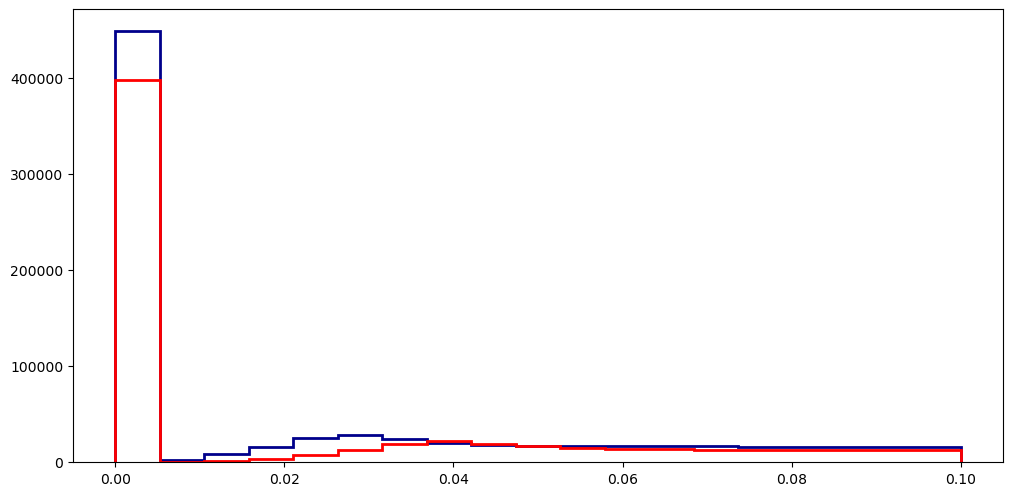

68.80257082653526


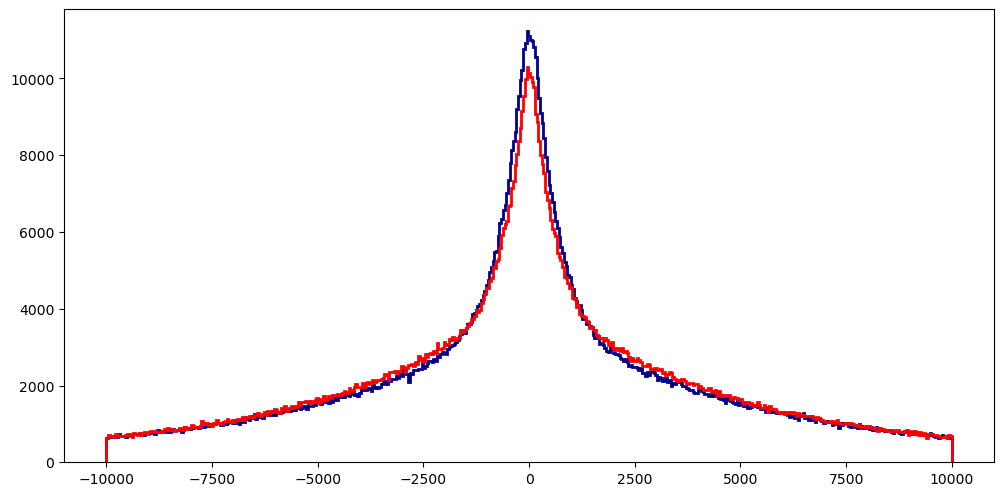

49.99735783501001


In [89]:
#For checkng ptcone, etacone
ptcone1 = df[18].values
ptcone2 = df[19].values
pt1 = df[6].values
pt2 = df[7].values
div1 = ptcone1/pt1
div2 = ptcone2/pt2
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0,0.1]
bins = np.linspace(xlims[0],xlims[1],20,endpoint=True)
plt.hist(div1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(div2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

#percent background using this cut
print(((len(div1[div1>0.02]))/(len(div1)))*100)

etacone1 = df[20].values
etacone2 = df[21].values
eta1 = df[8].values
eta2 = df[9].values
div1 = etacone1/eta1
div2 = etacone2/eta2
plt.figure(figsize=(12,6), dpi= 100)
xlims=[-10000,10000]
bins = np.linspace(xlims[0],xlims[1],500,endpoint=True)
plt.hist(div1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(div2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

#percent background using this cut
print(((len(div1[div1>0.065]))/(len(div1)))*100)

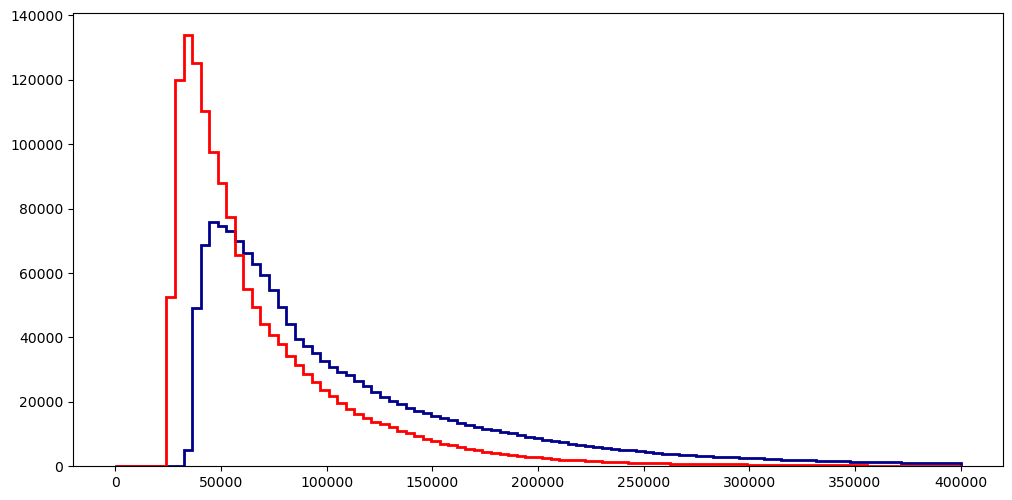

35007.6
25001.9


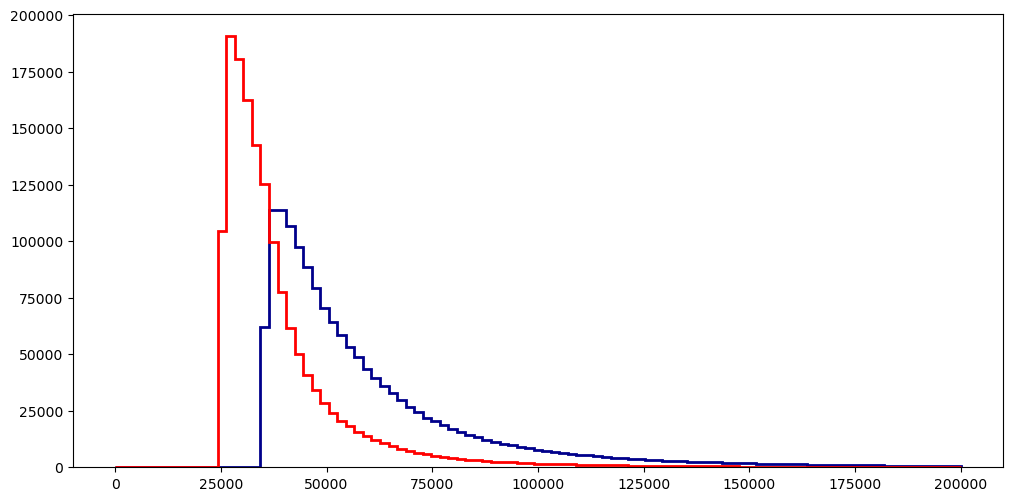

35000.0
25000.0


In [90]:
#for checking energy values
en1 = df[12].values
en2 = df[13].values
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0, 400000]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(en1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(en2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

print(min(en1))
print(min(en2))

pt1 = df[6].values
pt2 = df[7].values
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0, 200000]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(pt1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(pt2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

print(min(pt1))
print(min(pt2))

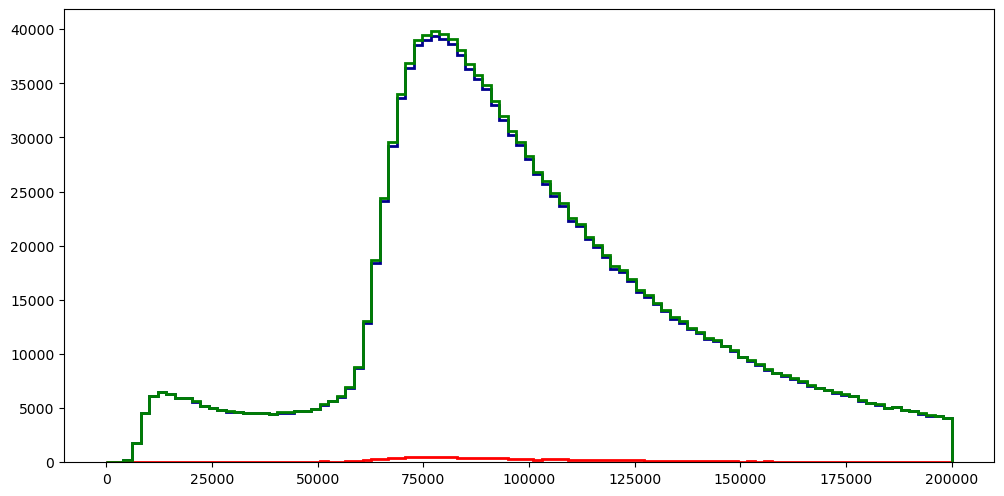

358.30579299012624
3224751.150828991


In [91]:
plt.figure(figsize=(12,6), dpi= 100)
inv_m = df[1].values
sigs = df[1][df[0]==1].values
bkgs = df[1][df[0]==0].values
xlims=[0, 200000]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
#plt.xlim((100000,150000))
plt.hist(bkgs, color = 'darkblue', histtype='step', bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step', bins=bins,linewidth=2)
plt.hist(inv_m, color = 'green', histtype='step', bins=bins,linewidth=2)
plt.show()

print(min(inv_m))
print(max(inv_m))

In [29]:
with open('./CSVfiles/ggH_sf.data', 'rb') as f:
    df=pickle.load(f)
df

,0,1,2,3,4,5
0,28.4857,55922600.0,0.000000,1.005130,0.999523,1.005130
1,28.4857,55922600.0,0.351687,0.970159,0.997608,0.970159
2,28.4857,55922600.0,0.553627,0.988219,0.998555,0.988219
3,28.4857,55922600.0,0.619412,0.986910,1.000000,0.986910
4,28.4857,55922600.0,0.619412,1.004190,0.994923,1.004190
...,...,...,...,...,...,...
1054705,28.4857,55922600.0,1.251330,0.952824,1.000000,0.952824
1054706,28.4857,55922600.0,1.251330,0.990247,1.000000,0.990247
1054707,28.4857,55922600.0,1.214120,0.998569,1.000000,0.998569
1054708,28.4857,55922600.0,1.320950,0.992051,0.998649,0.992051


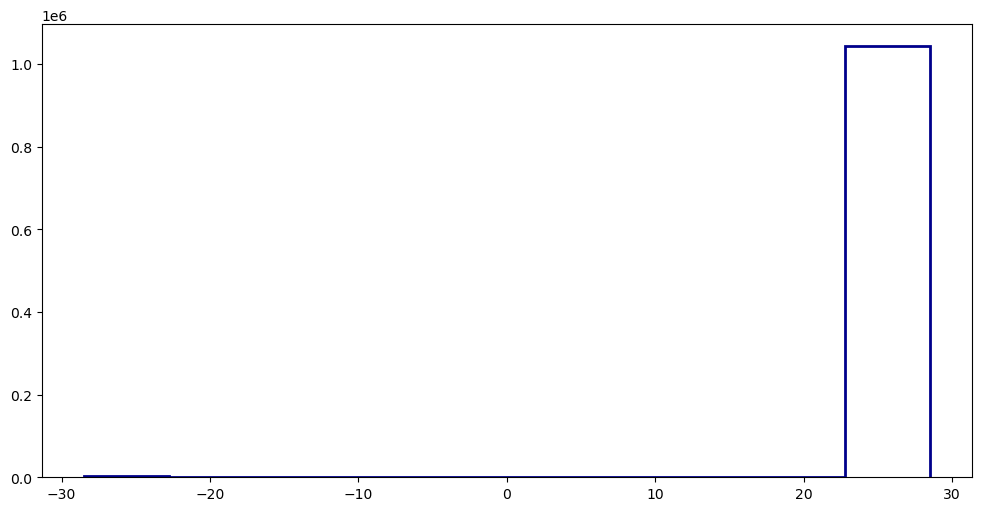

-28.4857
28.4857
2285


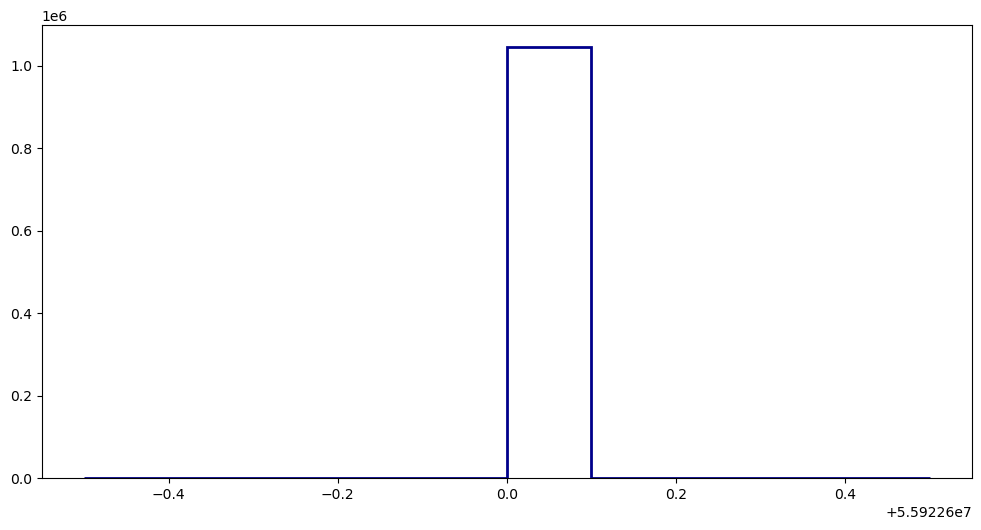

55922600.0
55922600.0


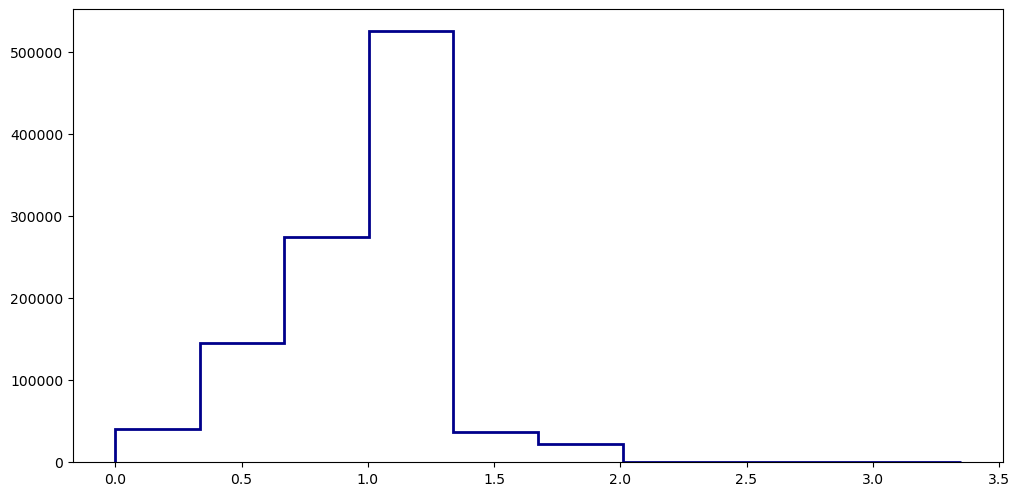

0.0
3.34815


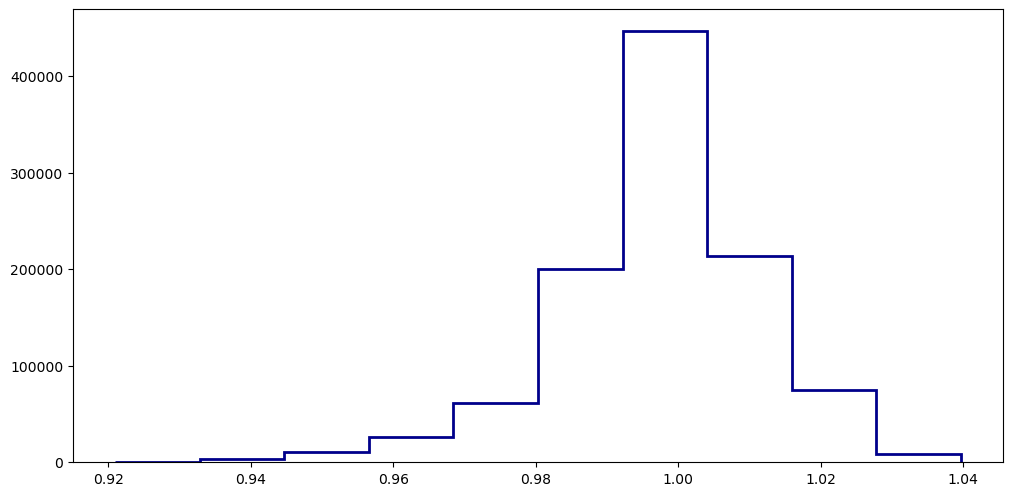

0.9209870000000001
1.0396299999999998


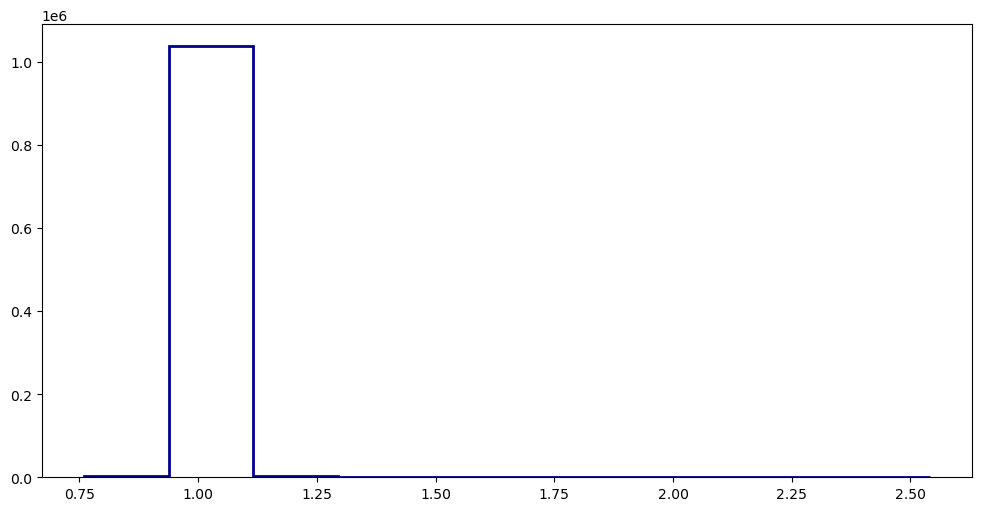

0.760089
2.54019


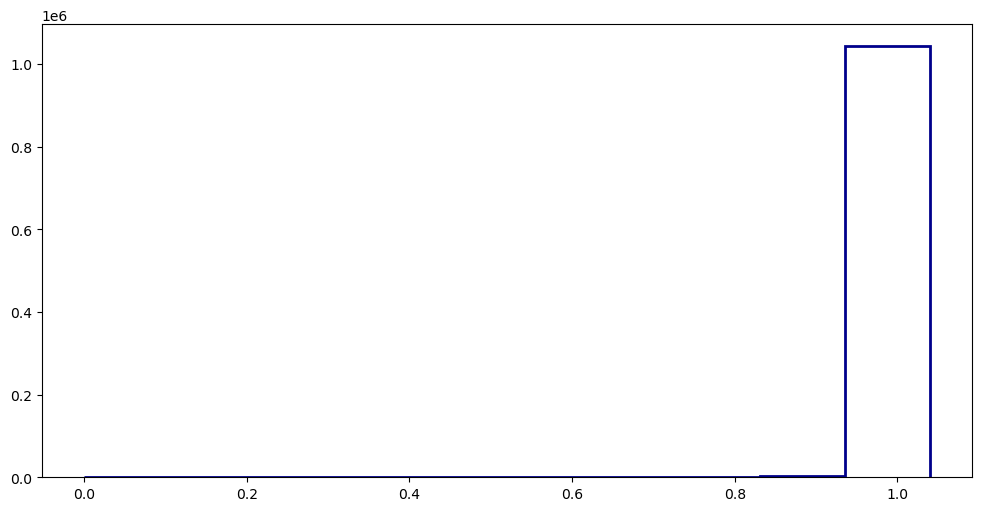

0.0
1.0396299999999998


In [8]:
#Look at scale factors 
mcWeight = df[0]
mcsum = df[1]
pileup = df[2]
photon = df[3]
btag = df[4]
phottrig = df[5]

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(mcWeight, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(mcWeight))
print(max(mcWeight))
print(len(mcWeight[mcWeight<28]))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(mcsum, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(mcsum))
print(max(mcsum))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(pileup, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(pileup))
print(max(pileup))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(photon, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(photon))
print(max(photon))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(btag, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(btag))
print(max(btag))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(phottrig, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(phottrig))
print(max(phottrig))